# Split Learning—Bank Marketing

>The following codes are demos only. It's **NOT for production** due to system security concerns, please **DO NOT** use it directly in production.

In this tutorial, we will use the bank's marketing model as an example to show how to accomplish split learning in vertical scenarios under the `SecretFlow` framework.
`SecretFlow` provides a user-friendly Api that makes it easy to apply your Keras model or PyTorch model to split learning scenarios to complete joint modeling tasks for vertical scenarios.

In this tutorial we will show you how to turn your existing 'Keras' model into a split learning model under `Secretflow` to complete federated multi-party modeling tasks.

## What is Split Learning？

The core idea of split learning is to split the network structure. Each device (silo) retains only a part of the network structure, and the sub-network structure of all devices is combined together to form a complete network model. 
In the training process, different devices (silos) only perform forward or reverse calculation on the local network structure, and transfer the calculation results to the next device. Multiple devices complete the training through joint model until convergence.

 <img alt="split_learning_tutorial.png" src="resources/split_learning_tutorial.png" width="600">  


**Alice**：have *data\_alice*，*model\_base\_alice*  
**Bob**: have *data\_bob*，*model\_base\_bob*，*model\_fuse*  

1. **Alice** uses its data to get *hidden0* through *model\_base\_Alice* and send it to Bob. 
2. **Bob** gets *hidden1* with its data through *model\_base\_bob*.
3. *hidden\_0* and *hidden\_1* are input to the *AggLayer* for aggregation, and the aggregated *hidden\_merge* is the output.
4. **Bob** input *hidden\_merge* to *model\_fuse*, get the gradient with *label* and send it back.
5. The gradient is split into two parts *g\_0*, *g\_1* through *AggLayer*, which are sent to **Alice** and **Bob** respectively.
6. Then **Alice** and **Bob** update their local base net with *g\_0* or *g\_1*.


## Task

Marketing is the banking industry in the ever-changing market environment, to meet the needs of customers, to achieve business objectives of the overall operation and sales activities. In the current environment of big data, data analysis provides a more effective analysis means for the banking industry. Customer demand analysis, understanding of target market trends and more macro market strategies can provide the basis and direction.  
  
The data from [kaggle](https://www.kaggle.com/janiobachmann/bank-marketing-dataset) is a set of classic marketing data bank, is a Portuguese bank agency telephone direct marketing activities, The target variable is whether the customer subscribes to deposit product.

## Data

1. The total sample size was 11162, including 8929 training set and 2233 test set
2. Feature dim is 16, target is binary classification
3. We have cut the data in advance. Alice holds the 4-dimensional basic attribute features, Bob holds the 12-dimensional bank transaction features, and only Alice holds the corresponding label

Let's start by looking at what our bank's marketing data look like?  

The original data is divided into Bank Alice and Bank Bob, which stores in Alice and Bob respectively. Here, CSV is the original data that has only been separated without pre-processing, we will use `secretflow preprocess` for FedData preprocess

In [1]:
%load_ext autoreload
%autoreload 2

import secretflow as sf
import matplotlib.pyplot as plt

sf.init(['alice', 'bob'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')

INFO:root:Run secretflow in simulation mode.
2023-04-12 09:52:26,305	INFO worker.py:1538 -- Started a local Ray instance.


### prepare data

In [2]:
import pandas as pd
from secretflow.utils.simulation.datasets import dataset

df = pd.read_csv(dataset('bank_marketing'), sep=';')

We assume that Alice is a new bank, and they only have the basic information of the user and purchased the label of financial products from other bank.

In [3]:
alice_data = df[["age", "job", "marital", "education", "y"]]
alice_data

,age,job,marital,education,y
0,30,unemployed,married,primary,no
1,33,services,married,secondary,no
2,35,management,single,tertiary,no
3,30,management,married,tertiary,no
4,59,blue-collar,married,secondary,no
...,...,...,...,...,...
4516,33,services,married,secondary,no
4517,57,self-employed,married,tertiary,no
4518,57,technician,married,secondary,no
4519,28,blue-collar,married,secondary,no


Bob is an old bank, they have the user's account balance, house, loan, and recent marketing feedback

In [4]:
bob_data = df[["default", "balance", "housing", "loan", "contact", 
             "day","month","duration","campaign","pdays","previous","poutcome"]]
bob_data

,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown
1,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure
2,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure
3,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown
4,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
4516,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown
4517,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown
4518,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown
4519,no,1137,no,no,cellular,6,feb,129,4,211,3,other


## Create Secretflow Environment

Create 2 entities in the Secretflow environment [Alice, Bob]
Where 'Alice' and 'Bob' are two PYU
Once you've constructed the two objects, you can happily start Splitting Learning

### Import Dependency

In [5]:
from secretflow.data.split import train_test_split
from secretflow.ml.nn import SLModel

2023-04-12 09:52:28.522508: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-12 09:52:28.556808: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-12 09:52:29.254695: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-12 09:52:29.254776: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-12 09:52:29.254784: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Ca

## Prepare Data

**Build Federated Table**


Federated table is a virtual concept that cross multiple parties, We define `VDataFrame` for vertical setting

1. The data of all parties in a federated table is stored locally and is not allowed to go out of the domain.

2. No one has access to data store except the party that owns the data.

3. Any operation of the federated table will be scheduled by the driver to each worker, and the execution instructions will be delivered layer by layer until the Python Runtime of the specific worker. The framework ensures that only `worker.device` and `Object`. device can operate data at the same time.

4. Federated tables are designed to management and manipulation multi-party data from a central perspective.

5. Interfaces to `Federated Table` are aligned to `pandas.DataFrame` to reduce the cost of multi-party data operations.

6. The SecretFlow framework provides Plain&Ciphertext hybrid programming capabilities. Vertical federated tables are built using `SPU`, and `MPC-PSI` is used to safely get intersection and align data from all parties.

<img alt="vdataframe.png" src="resources/vdataframe.png" width="600">  



VDataFrame provides `read_csv` interface similar to pandas, except that `secretflow.read_csv` receives a dictionary that defines the path of data for both parties. We can use `secretflow.vertical.read_csv` to build the `VDataFrame`.
```
read_csv(file_dict,delimiter,ppu,keys,drop_key)
    filepath: Path of the participant file. The address can be a relative or absolute path to a local file
    ppu: PPU Device for PSI; If this parameter is not specified, data must be prealigned
    keys: Key for intersection
```

Create spu object

In [6]:
spu = sf.SPU(sf.utils.testing.cluster_def(['alice', 'bob']))

In [7]:
from secretflow.utils.simulation.datasets import load_bank_marketing

# Alice has the first four features,
# while bob has the left features
data = load_bank_marketing(parts={alice: (0, 4), bob: (4, 16)}, axis=1)
# Alice holds the label.
label = load_bank_marketing(parts={alice: (16, 17)}, axis=1)

`data` is a vertically federated table. It only has the `Schema` of all the data globally

Let's take a closer look at VDF data management 

As can be seen from an example, the `age` field belongs to Alice, so the corresponding column can be obtained in the partition of Alice, but Bob will report `KeyError` error when trying to obtain age.  
There is a concept of `Partition`, which is a data fragment defined by us. Each Partition has its own device to which it belongs, and only the device that belongs can operate data.

In [8]:
data['age'].partitions[alice].data

In [9]:
# You can uncomment this and you will get a KeyError.
# data['age'].partitions[bob]

We then do data preprocessing on the `VDataFrame`.。  
Here we take `LabelEncoder` and `MinMaxScaler` as examples. These two preprocessor functions have corresponding concepts in `SkLearn` and their use methods are similar to those in `SkLearn`

In [10]:
from secretflow.preprocessing.scaler import MinMaxScaler
from secretflow.preprocessing.encoder import LabelEncoder

In [11]:
encoder = LabelEncoder()
data['job'] = encoder.fit_transform(data['job'])
data['marital'] = encoder.fit_transform(data['marital'])
data['education'] = encoder.fit_transform(data['education'])
data['default'] = encoder.fit_transform(data['default'])
data['housing'] = encoder.fit_transform(data['housing'])
data['loan'] = encoder.fit_transform(data['loan'])
data['contact'] = encoder.fit_transform(data['contact'])
data['poutcome'] = encoder.fit_transform(data['poutcome'])
data['month'] = encoder.fit_transform(data['month'])
label = encoder.fit_transform(label)

(SPURuntime pid=821702) 2023-04-12 09:52:33.680 [error] [context.cc:operator():132] connect to rank=1 failed with error [external/yacl/yacl/link/transport/channel_brpc.cc:368] send, rpc failed=112, message=[E111]Fail to connect Socket{id=0 addr=127.0.0.1:60349} (0x0x4f78d00): Connection refused [R1][E112]Not connected to 127.0.0.1:60349 yet, server_id=0 [R2][E112]Not connected to 127.0.0.1:60349 yet, server_id=0 [R3][E112]Not connected to 127.0.0.1:60349 yet, server_id=0


In [12]:
print(f"label= {type(label)},\ndata = {type(data)}")

label= <class 'secretflow.data.vertical.dataframe.VDataFrame'>,
data = <class 'secretflow.data.vertical.dataframe.VDataFrame'>


Standardize data via MinMaxScaler

In [13]:
scaler = MinMaxScaler()

data = scaler.fit_transform(data)


Next we divide the data set into train-set and test-set

In [14]:
from secretflow.data.split import train_test_split
random_state = 1234
train_data,test_data = train_test_split(data, train_size=0.8, random_state=random_state)
train_label,test_label = train_test_split(label, train_size=0.8, random_state=random_state)

(SPURuntime pid=821702) 2023-04-12 09:52:34.680 [error] [context.cc:operator():132] connect to rank=1 failed with error [external/yacl/yacl/link/transport/channel_brpc.cc:368] send, rpc failed=112, message=[E112]Not connected to 127.0.0.1:60349 yet, server_id=0 [R1][E112]Not connected to 127.0.0.1:60349 yet, server_id=0 [R2][E112]Not connected to 127.0.0.1:60349 yet, server_id=0 [R3][E112]Not connected to 127.0.0.1:60349 yet, server_id=0


(_run pid=819020) /opt/anaconda3/envs/limingbo_sf/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
(_run pid=819020)   warnings.warn(
(_run pid=819036) /opt/anaconda3/envs/limingbo_sf/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
(_run pid=819036)   warnings.warn(


**Summary:** At this point, we have completed the definition of **federated tables**, **data preprocessing**, and **training set and test set partitioning**
The secretFlow framework defines a set of operations to be built on the federated table (its logical counterpart is `pandas.DataFrame`). The secretflow framework defines a set of operations to be built on the federated table (its logical counterpart is `sklearn`) Refer to our documentation and API introduction to learn more about other features

## Introduce Model

**local version**: 
For this task, a basic DNN can be completed, input 16-dimensional features, through a DNN network, output the probability of positive and negative samples.


**Federate version**：
* Alice：
    - base_net: Input 4-dimensional feature and go through a DNN network to get hidden
    - fuse_net: Receive hidden features calculated by Alice and Bob, input them to FUSENET for feature fusion, and complete the forward process and backward process
* Bob：
    - base_net: Input 12-dimensional features, get hidden through a DNN network, and then send hidden to Alice to complete the following operation

### Define Model

Next we start creating the federated model 
we define SLTFModel and SLTorchModel(WIP), which are used to build split learning of vertical scene. We define a simple and easy to use extensible interface, which can easily transform your existing Model into SF-Model, and then conduct vertical scene federation modeling

Split learning is to break up a model so that one part is executed locally on the data and the other part is executed on the label side.
First let's define the locally executed model -- base_model

In [15]:
def create_base_model(input_dim, output_dim,  name='base_model'):
    # Create model
    def create_model():
        from tensorflow import keras
        from tensorflow.keras import layers
        import tensorflow as tf
        model = keras.Sequential(
            [
                keras.Input(shape=input_dim),
                layers.Dense(100,activation ="relu" ),
                layers.Dense(output_dim, activation="relu"),
            ]
        )
        # Compile model
        model.summary()
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=["accuracy",tf.keras.metrics.AUC()])
        return model
    return create_model


We use create_base_model to create their base models for 'Alice' and 'Bob', respectively

In [16]:
# prepare model
hidden_size = 64
# get the number of features of each party.
# When the input data changes, the network automatically adjusts to the input data
alice_input_feature_num = train_data.values.partition_shape()[alice][1]
bob_input_feature_num = train_data.values.partition_shape()[bob][1]

model_base_alice = create_base_model(alice_input_feature_num, hidden_size)
model_base_bob = create_base_model(bob_input_feature_num, hidden_size)

In [17]:
model_base_alice()
model_base_bob()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               500       
                                                                 
 dense_1 (Dense)             (None, 64)                6464      
                                                                 
Total params: 6,964
Trainable params: 6,964
Non-trainable params: 0
_________________________________________________________________


2023-04-12 09:52:35.081108: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-04-12 09:52:35.081197: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               1300      
                                                                 
 dense_3 (Dense)             (None, 64)                6464      
                                                                 
Total params: 7,764
Trainable params: 7,764
Non-trainable params: 0
_________________________________________________________________


Next we define the side with the label, or the server-side model -- fuse_model
In the definition of fuse_model, we need to correctly define `loss`, `optimizer`, and `metrics`. This is compatible with all configurations of your existing Keras model

In [18]:
def create_fuse_model(input_dim, output_dim, party_nums, name='fuse_model'):
    def create_model():
        from tensorflow import keras
        from tensorflow.keras import layers
        import tensorflow as tf
        # input
        input_layers = []
        for i in range(party_nums):
            input_layers.append(keras.Input(input_dim,))
        
        merged_layer = layers.concatenate(input_layers)
        fuse_layer = layers.Dense(64, activation='relu')(merged_layer)
        output = layers.Dense(output_dim, activation='sigmoid')(fuse_layer)

        model = keras.Model(inputs=input_layers, outputs=output)
        model.summary()
        
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=["accuracy",tf.keras.metrics.AUC()])
        return model
    return create_model

In [19]:
model_fuse = create_fuse_model(
    input_dim=hidden_size, party_nums=2, output_dim=1)

In [20]:
model_fuse()

Model: "model"
__________________________________________________________________________________________________
(SPURuntime pid=821702) 2023-04-12 09:52:35.681 [error] [context.cc:operator():132] connect to rank=1 failed with error [external/yacl/yacl/link/transport/channel_brpc.cc:368] send, rpc failed=112, message=[E112]Not connected to 127.0.0.1:60349 yet, server_id=0 [R1][E112]Not connected to 127.0.0.1:60349 yet, server_id=0 [R2][E112]Not connected to 127.0.0.1:60349 yet, server_id=0 [R3][E112]Not connected to 127.0.0.1:60349 yet, server_id=0
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 64)]         0           []                               
                                                

### Create Split Learning Model
Secretflow provides the split learning model `SLModel`
To initial SLModel only need 3 parameters
* base_model_dict: A dictionary needs to be passed in all clients participating in the training along with base_model mappings
* device_y: PYU, which device has label
* model_fuse: The fusion model

Define base_model_dict  
```python
base_model_dict:Dict[PYU,model_fn]
```

In [21]:
base_model_dict = {
    alice: model_base_alice,
    bob:   model_base_bob
}

In [22]:
from secretflow.security.privacy import DPStrategy, GaussianEmbeddingDP, LabelDP

# Define DP operations
train_batch_size = 128
gaussian_embedding_dp = GaussianEmbeddingDP(
    noise_multiplier=0.5,
    l2_norm_clip=1.0,
    batch_size=train_batch_size,
    num_samples=train_data.values.partition_shape()[alice][0],
    is_secure_generator=False,
)
dp_strategy_alice = DPStrategy(embedding_dp=gaussian_embedding_dp)
label_dp = LabelDP(eps=64.0)
dp_strategy_bob = DPStrategy(label_dp=label_dp)
dp_strategy_dict = {alice: dp_strategy_alice, bob: dp_strategy_bob}
dp_spent_step_freq = 10

In [23]:
sl_model = SLModel(
    base_model_dict=base_model_dict, 
    device_y=alice,  
    model_fuse=model_fuse,
    dp_strategy_dict=dp_strategy_dict,)

INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.tensorflow.sl_base.PYUSLTFModel'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.tensorflow.sl_base.PYUSLTFModel'> with party bob.


In [24]:
sf.reveal(test_data.partitions[alice].data), sf.reveal(test_label.partitions[alice].data)

(           age       job  marital  education
 1426  0.279412  0.181818      0.5   0.333333
 416   0.176471  0.636364      1.0   0.333333
 3977  0.264706  0.000000      0.5   0.666667
 2291  0.338235  0.000000      0.5   0.333333
 257   0.132353  0.909091      1.0   0.333333
 ...        ...       ...      ...        ...
 1508  0.264706  0.818182      1.0   0.333333
 979   0.544118  0.090909      0.0   0.000000
 3494  0.455882  0.090909      0.5   0.000000
 42    0.485294  0.090909      0.5   0.333333
 1386  0.455882  0.636364      0.5   0.333333
 
 [905 rows x 4 columns],
       y
 1426  0
 416   0
 3977  0
 2291  0
 257   0
 ...  ..
 1508  0
 979   0
 3494  0
 42    0
 1386  0
 
 [905 rows x 1 columns])

In [25]:
sf.reveal(train_data.partitions[alice].data), sf.reveal(train_label.partitions[alice].data)

(           age       job  marital  education
 1106  0.235294  0.090909      0.5   0.333333
 1309  0.176471  0.363636      0.5   0.333333
 2140  0.411765  0.272727      1.0   0.666667
 2134  0.573529  0.454545      0.5   0.333333
 960   0.485294  0.818182      0.5   0.333333
 ...        ...       ...      ...        ...
 664   0.397059  0.090909      1.0   0.333333
 3276  0.235294  0.181818      0.5   0.666667
 1318  0.220588  0.818182      0.5   0.333333
 723   0.220588  0.636364      0.5   0.333333
 2863  0.176471  0.363636      1.0   0.666667
 
 [3616 rows x 4 columns],
       y
 1106  0
 1309  0
 2140  1
 2134  0
 960   0
 ...  ..
 664   0
 3276  0
 1318  0
 723   0
 2863  0
 
 [3616 rows x 1 columns])

In [26]:
history =  sl_model.fit(train_data,
             train_label,
             validation_data=(test_data,test_label),
             epochs=10, 
             batch_size=train_batch_size,
             shuffle=True,
             verbose=1,
             validation_freq=1,
             dp_spent_step_freq=dp_spent_step_freq,)

INFO:root:SL Train Params: {'self': <secretflow.ml.nn.sl.sl_model.SLModel object at 0x7f6cf032a0d0>, 'x': VDataFrame(partitions={alice_: Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7f6cf073bee0>), bob_: Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7f6cf073b580>)}, aligned=True), 'y': VDataFrame(partitions={alice_: Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7f6cf073c7f0>)}, aligned=True), 'batch_size': 128, 'epochs': 10, 'verbose': 1, 'callbacks': None, 'validation_data': (VDataFrame(partitions={alice_: Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7f6cf073b730>), bob_: Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7f6cf073b4c0>)}, aligned=True), VDataFrame(partitions={alice_: Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7f6cf073ce80>)}, aligned=True)), 'shuffle': True, 'sample_weight': None, 'validation_freq': 1, 'dp_spent_step_freq': 10, 'dataset_builder

(SPURuntime pid=821702) 2023-04-12 09:52:36.681 [error] [context.cc:operator():132] connect to rank=1 failed with error [external/yacl/yacl/link/transport/channel_brpc.cc:368] send, rpc failed=112, message=[E112]Not connected to 127.0.0.1:60349 yet, server_id=0 [R1][E112]Not connected to 127.0.0.1:60349 yet, server_id=0 [R2][E112]Not connected to 127.0.0.1:60349 yet, server_id=0 [R3][E112]Not connected to 127.0.0.1:60349 yet, server_id=0


(pid=822020) 2023-04-12 09:52:38.669361: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(pid=822020) 2023-04-12 09:52:38.708954: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=822061) 2023-04-12 09:52:38.731589: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(pid=822061) 2023-04-12 09:52:38.771335: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=822020) 2023-04-12 09:52:39.611190: W tensorflow/stream_executor/platform/defau

(PYUSLTFModel pid=822061) Model: "sequential"
(PYUSLTFModel pid=822061) _________________________________________________________________
(PYUSLTFModel pid=822061)  Layer (type)                Output Shape              Param #   
(PYUSLTFModel pid=822061) =================================================================
(PYUSLTFModel pid=822061)  dense (Dense)               (None, 100)               1300      
(PYUSLTFModel pid=822061)                                                                  
(PYUSLTFModel pid=822061)  dense_1 (Dense)             (None, 64)                6464      
(PYUSLTFModel pid=822061)                                                                  
(PYUSLTFModel pid=822061) =================================================================
(PYUSLTFModel pid=822061) Total params: 7,764
(PYUSLTFModel pid=822061) Trainable params: 7,764
(PYUSLTFModel pid=822061) Non-trainable params: 0
(PYUSLTFModel pid=822061) ______________________________________________

100%|██████████| 29/29 [00:00<00:00, 50.54it/s, epoch: 10/10 -  train_loss:0.2361142784357071  train_accuracy:0.9057112336158752  train_auc_1:0.8704230785369873  val_loss:0.28809645771980286  val_accuracy:0.8784530162811279  val_auc_1:0.8461034297943115 ]


Let's visualize the training process

In [27]:
print(history)
print(history.keys())

{'train_loss': [0.50489587, 0.36828813, 0.32504964, 0.3581692, 0.3279478, 0.28736836, 0.27136606, 0.26769143, 0.24492541, 0.23611428], 'train_accuracy': [0.7563606, 0.88039774, 0.8940341, 0.8691925, 0.88025445, 0.8962823, 0.89602274, 0.889278, 0.9015487, 0.90571123], 'train_auc_1': [0.49732718, 0.58159745, 0.6500523, 0.7075063, 0.74136925, 0.7777636, 0.81469756, 0.8526156, 0.85277843, 0.8704231], 'val_loss': [0.3867801, 0.372496, 0.37217382, 0.35997438, 0.34301913, 0.33498412, 0.3194976, 0.30175072, 0.2974702, 0.28809646], 'val_accuracy': [0.8729282, 0.8729282, 0.8729282, 0.8729282, 0.8729282, 0.8729282, 0.87071824, 0.8729282, 0.87071824, 0.878453], 'val_auc_1': [0.6002312, 0.61140895, 0.64276826, 0.6812328, 0.7424271, 0.77070993, 0.8118547, 0.83978534, 0.83844244, 0.8461034]}
dict_keys(['train_loss', 'train_accuracy', 'train_auc_1', 'val_loss', 'val_accuracy', 'val_auc_1'])


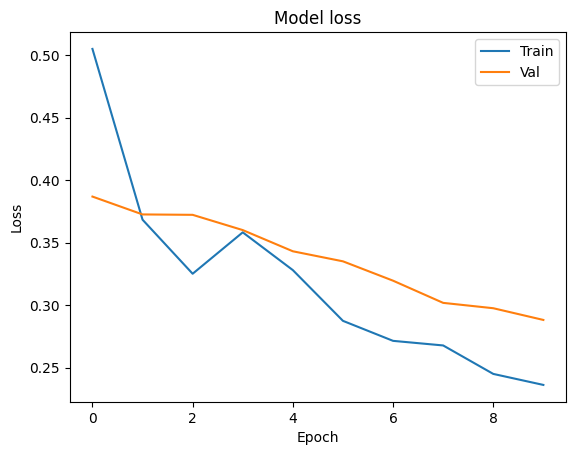

In [28]:
# Plot the change of loss during training
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Val'], loc='upper right')
plt.show()

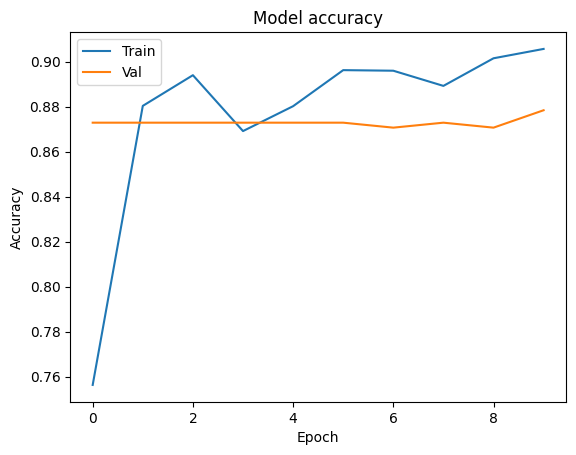

In [29]:
# Plot the change of accuracy during training
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

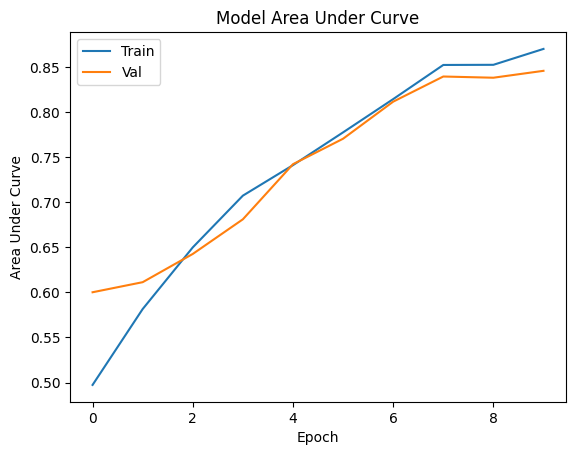

In [30]:
# Plot the Area Under Curve(AUC) of loss during training
plt.plot(history['train_auc_1'])
plt.plot(history['val_auc_1'])
plt.title('Model Area Under Curve')
plt.ylabel('Area Under Curve')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Let's call the evaluation function

In [31]:
global_metric = sl_model.evaluate(test_data, test_label, batch_size=128)
print(global_metric)

Evaluate Processing:: 100%|██████████| 8/8 [00:00<00:00, 143.40it/s, loss:0.2869385778903961 accuracy:0.8762431144714355 auc_1:0.8490478992462158]

{'loss': 0.28693858, 'accuracy': 0.8762431, 'auc_1': 0.8490479}


## Contrast to local model

#### Model
The model structure is consistent with the model of split learning above, but only the model structure of Alice is used here. The model definition refers to the code below.
#### Data
The data also use kaggle's anti-fraud data. Here, we just use Alice's data of the new bank.

In [32]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.model_selection import train_test_split

def create_model():

    model = keras.Sequential(
        [
            keras.Input(shape=4),
            layers.Dense(100,activation ="relu" ),
            layers.Dense(64, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ]
    )
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=["accuracy",tf.keras.metrics.AUC()])
    return model

single_model = create_model()

data process

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
alice_data.loc[:, 'job'] = encoder.fit_transform(alice_data['job'])
alice_data.loc[:, 'marital'] = encoder.fit_transform(alice_data['marital'])
alice_data.loc[:, 'education'] = encoder.fit_transform(alice_data['education'])
alice_data.loc[:, 'y'] =  encoder.fit_transform(alice_data['y'])

/tmp/ipykernel_818514/593075830.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alice_data.loc[:, 'job'] = encoder.fit_transform(alice_data['job'])
/tmp/ipykernel_818514/593075830.py:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  alice_data.loc[:, 'job'] = encoder.fit_transform(alice_data['job'])
/tmp/ipykernel_818514/593075830.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [34]:
y = alice_data['y']
alice_data = alice_data.drop(columns=['y'],inplace=False)

In [35]:
scaler = MinMaxScaler()
alice_data = scaler.fit_transform(alice_data)

In [36]:
train_data,test_data = train_test_split(alice_data,train_size=0.8,random_state=random_state)
train_label,test_label = train_test_split(y,train_size=0.8,random_state=random_state)

In [37]:
test_data.shape

(905, 4)

In [38]:
history =single_model.fit(train_data,train_label,validation_data=(test_data,test_label),batch_size=128,epochs=10,shuffle=False)

Epoch 1/10
29/29 [==============================] - 1s 14ms/step - loss: 0.4976 - accuracy: 0.8728 - auc_3: 0.4485 - val_loss: 0.4046 - val_accuracy: 0.8729 - val_auc_3: 0.4192
Epoch 2/10
29/29 [==============================] - 0s 4ms/step - loss: 0.3705 - accuracy: 0.8877 - auc_3: 0.4561 - val_loss: 0.3991 - val_accuracy: 0.8729 - val_auc_3: 0.4115
Epoch 3/10
29/29 [==============================] - 0s 4ms/step - loss: 0.3671 - accuracy: 0.8877 - auc_3: 0.4344 - val_loss: 0.3944 - val_accuracy: 0.8729 - val_auc_3: 0.4112
Epoch 4/10
29/29 [==============================] - 0s 4ms/step - loss: 0.3622 - accuracy: 0.8877 - auc_3: 0.4432 - val_loss: 0.3911 - val_accuracy: 0.8729 - val_auc_3: 0.4203
Epoch 5/10
29/29 [==============================] - 0s 4ms/step - loss: 0.3606 - accuracy: 0.8877 - auc_3: 0.4522 - val_loss: 0.3887 - val_accuracy: 0.8729 - val_auc_3: 0.4356
Epoch 6/10
29/29 [==============================] - 0s 4ms/step - loss: 0.3588 - accuracy: 0.8877 - auc_3: 0.4619 - val

Referring to the above visualization code, the training process of a local model can also be visualized

### Summary
The above two experiments simulate a typical vertical scene training problem. Alice and Bob have the same sample group, but each side has only a part of the features. If Alice only uses her own data to train the model, an accuracy of **0.872**, AUC **0.53** model can be obtained. However, if Bob's data are combined, a model with an accuracy of **0.893**  and AUC **0.883** can be obtained.

## Conclusion

* This tutorial introduces what is split learning and how to do it in secretFlow  
* It can be seen from the experimental data that split learning has significant advantages in expanding sample dimension and improving model effect through joint multi-party training
* This tutorial uses plaintext aggregation to demonstrate, without considering the leakage problem of hidden layer. Secretflow provides AggLayer to avoid the leakage problem of hidden layer plaintext transmission through MPC,TEE,HE, and DP. If you are interested, please refer to relevant documents.
* Next, you may want to try different data sets, you need to vertically shard the data first and then follow the flow of this tutorial
